# Part #04: Model Validation

## Step #01: Feature Selection REVISITED!

### Set up the workspace

In [1]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
sns.set()
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, learning_curve, RandomizedSearchCV, validation_curve
from xgboost import XGBRegressor

In [2]:
# Read the results from before:
with open("./assets/preprocessing_results.pkl", mode="rb") as file_bin:
    resulst = pickle.load(file_bin)

In [3]:
# Unpack train and test sets:
feature_names, X_train, X_test, y_train, y_test = resulst.values()

### Perform step-wise feature elimination to exclude less important features

- What is feature elimination?
> - Feature elimination, also known as feature selection, is the process of selecting a subset of features from a larger set of available features.
> - In machine learning, features refer to the input variables or attributes that are used to train a model and make predictions.
> - Feature elimination is performed to improve model performance, reduce overfitting, and enhance interpretability by focusing on the most informative and relevant features.

- What is step-wise feature elimination?
> - Step-wise feature elimination is a systematic approach to feature selection that iteratively removes less important features from the dataset.
> - The process typically involves the following steps:
>> - Initialization,
>> - Feature importance calculation,
>> - Feature elimination,
>> - Model retraining,
>> - Stopping criteria,
>> - Iterative process,
>> - Final model evaluation.

In [4]:
# Recreate the df for training & test sets:
X_train_df = pd.DataFrame(data=X_train, columns=feature_names)
X_test_df = pd.DataFrame(data=X_test, columns=feature_names)

In [5]:
# Instantiate a candidate model:
xgb_reg = XGBRegressor()

In [6]:
# Define a scoring function(s):
r2 = make_scorer(r2_score, greater_is_better=True)

Validating current performance...
Validating current performance done in 0.20 minutes!

Validating longitude...
Validating longitude done in 0.15 minutes!

Validating latitude...
Validating latitude done in 0.15 minutes!

Validating housing_median_age...
Validating housing_median_age done in 0.17 minutes!

Validating total_rooms...
Validating total_rooms done in 0.17 minutes!

Validating population...
Validating population done in 0.15 minutes!

Validating median_income...
Validating median_income done in 0.12 minutes!

Validating ocean_proximity_1H OCEAN...
Validating ocean_proximity_1H OCEAN done in 0.18 minutes!

Validating ocean_proximity_INLAND...
Validating ocean_proximity_INLAND done in 0.17 minutes!

Validating ocean_proximity_NEAR BAY...
Validating ocean_proximity_NEAR BAY done in 0.17 minutes!

Validating ocean_proximity_NEAR OCEAN...
Validating ocean_proximity_NEAR OCEAN done in 0.17 minutes!

                             min  mean   max
ocean_proximity_NEAR OCEAN  0.82  0.8

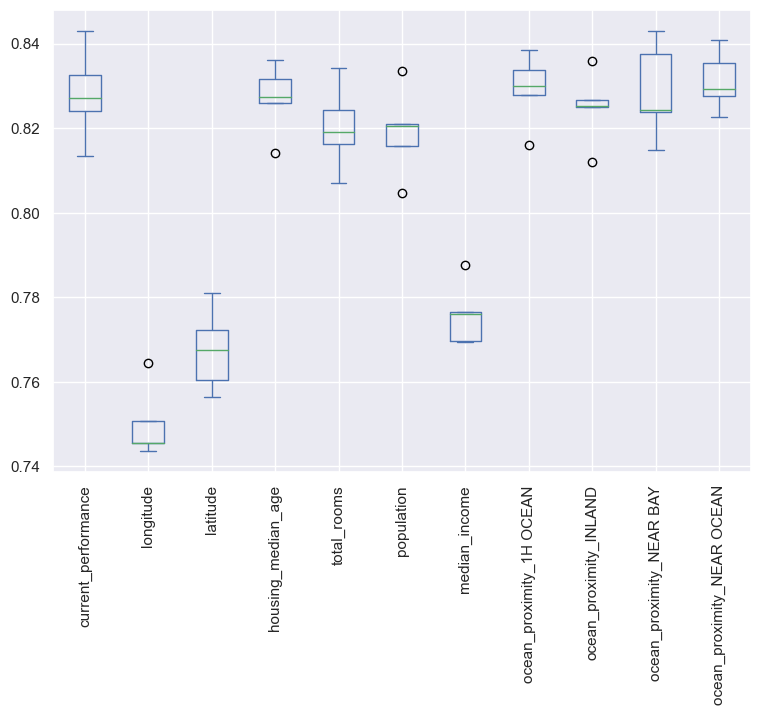

In [7]:
%%time
# Compare different features:
%run "./recipes/compare_features.py";
results = compare_features(xgb_reg, X_train_df, y_train, r2, cv=10);

In [8]:
# Determine irrelevant features:
n_features = 6
irrelevant_features = [f for f in results.index[:n_features] if f != "current_performance"]
irrelevant_features

['ocean_proximity_NEAR OCEAN',
 'ocean_proximity_1H OCEAN',
 'ocean_proximity_NEAR BAY',
 'housing_median_age',
 'ocean_proximity_INLAND']

In [9]:
# Drop irrelevant features:
X_train_df = X_train_df.drop(irrelevant_features, axis=1)

Validating current performance...
Validating current performance done in 0.20 minutes!

Validating longitude...
Validating longitude done in 0.13 minutes!

Validating latitude...
Validating latitude done in 0.13 minutes!

Validating total_rooms...
Validating total_rooms done in 0.13 minutes!

Validating population...
Validating population done in 0.13 minutes!

Validating median_income...
Validating median_income done in 0.10 minutes!

                      min  mean   max
current_performance  0.81  0.83  0.84
population           0.80  0.82  0.84
total_rooms          0.80  0.82  0.83
median_income        0.77  0.77  0.78
latitude             0.65  0.67  0.69
longitude            0.62  0.64  0.65


CPU times: total: 2min 43s
Wall time: 54.1 s


<Figure size 640x480 with 0 Axes>

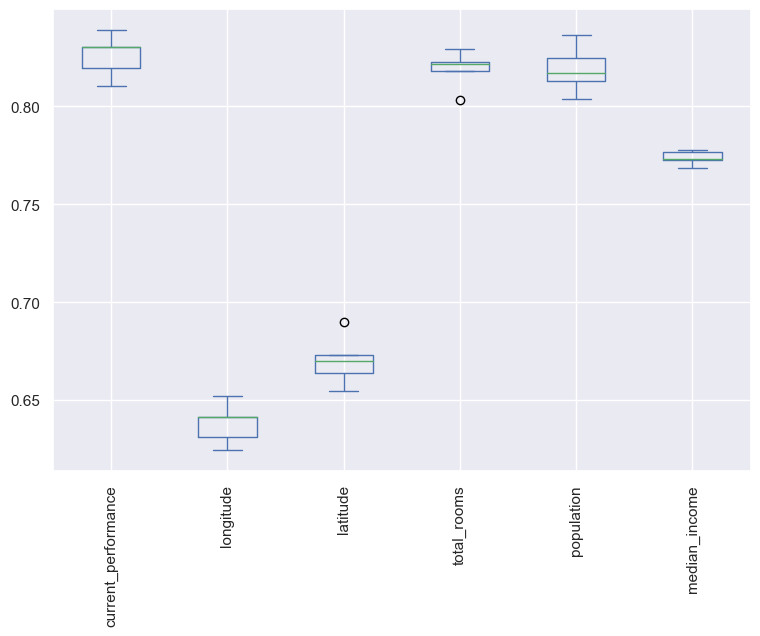

In [10]:
%%time
# Compare remaining features:
%run "./recipes/compare_features.py";
results = compare_features(xgb_reg, X_train_df, y_train, r2, cv=10);

In [11]:
# Drop irrelevant features from test set:
X_test_df = X_test_df.drop(irrelevant_features, axis=1)

In [12]:
# Convert train and test set into numpy arrays:
X_train = X_train_df.to_numpy(dtype=np.float32)
X_test = X_test_df.to_numpy(dtype=np.float32)

In [13]:
# Save feature names for later:
feature_names = X_train_df.columns.tolist()

## Step #02: Plotting the Learning Curve

> - We can gain further insight by exploring the behavior of the model as a function of the number of training points, which we can do by using increasingly larger subsets of the data to fit our model.
> - A plot of the training/validation score with respect to the size of the training set is sometimes known as a learning curve.
> - The general behavior we would expect from a learning curve is this:
>> - A model of a given complexity will overfit a small dataset: this means the training score will be relatively high, while the validation score will be relatively low.
>> - A model of a given complexity will underfit a large dataset: this means that the training score will decrease, but the validation score will increase.
>> - A model will never, except by chance, give a better score to the validation set than the training set: this means the curves should keep getting closer together but
never cross.

In [14]:
%%time
# Perform CV on different sample sizes:
train_sizes, train_scores, test_scores = learning_curve(
    xgb_reg,
    X_train,
    y_train,
    train_sizes=np.linspace(start=0.2, stop=1.0, num=5),
    cv=10,
    scoring=r2,
    random_state=42
)

CPU times: total: 3min 22s
Wall time: 1min 22s


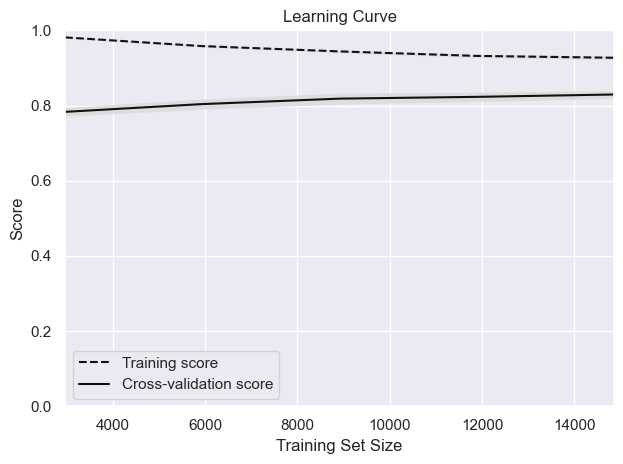

In [15]:
# Plot the learning curve:
%run "./recipes/plot_learning_curve.py"
plot_learning_curve(train_sizes, train_scores, test_scores);

## Step #03: Plotting the Validation Curve(s)

- What are hyperparameters?
> - In machine learning, hyperparameters are the configuration settings of a model that are not learned from the data, but rather set by the developer before training the model.
> - These parameters influence the learning process and affect the model's performance and generalization capability.

- So the next step is to understand how the performance of a model changes as the value of some hyperparameter changes, starting by a DUMMY (but intuitive) approach and then proceeding to a MORE STRUCTURED one (using different search techniques) in the next section.

### Tune `max_depth`

In [16]:
# Instantiate the model:
xgb_reg = XGBRegressor(random_state=42);

In [17]:
# Create range of values for the hyperparameter in question:
max_depth = [int(x) for x in np.linspace(start=1, stop=10, num=10)]

In [18]:
%%time
# Perform CV using different hyperparametr values:
train_scores, test_scores = validation_curve(
    xgb_reg,
    X_train,
    y_train,
    param_name="max_depth",
    param_range=max_depth,
    cv=3,
    scoring=r2
)

CPU times: total: 2min 14s
Wall time: 1min 1s


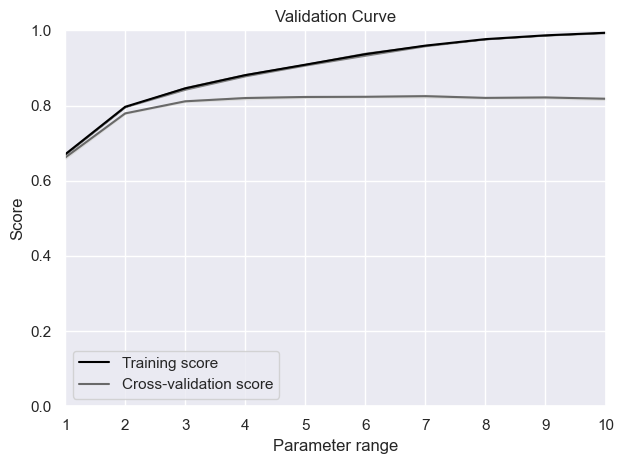

In [19]:
# Plot the validation curve:
%run "./recipes//plot_validation_curve.py"
plot_validation_curve(max_depth, train_scores, test_scores)

In [20]:
best_max_depth = max_depth[test_scores.mean(axis=1).argmax()]
best_max_depth

7

### Tune `learning_rate`

In [21]:
# Instantiate the model:
xgb_reg = XGBRegressor(
    max_depth=best_max_depth,
    random_state=42
);

In [22]:
# Create range of values for the hyperparameter in question:
learning_rate = [x for x in np.linspace(start=0.01, stop=0.1, num=5)]

In [23]:
%%time
# Perform CV using different hyperparametr values:
train_scores, test_scores = validation_curve(
    xgb_reg,
    X_train,
    y_train,
    param_name="learning_rate",
    param_range=learning_rate,
    cv=3,
    scoring=r2
)

CPU times: total: 1min 36s
Wall time: 36.2 s


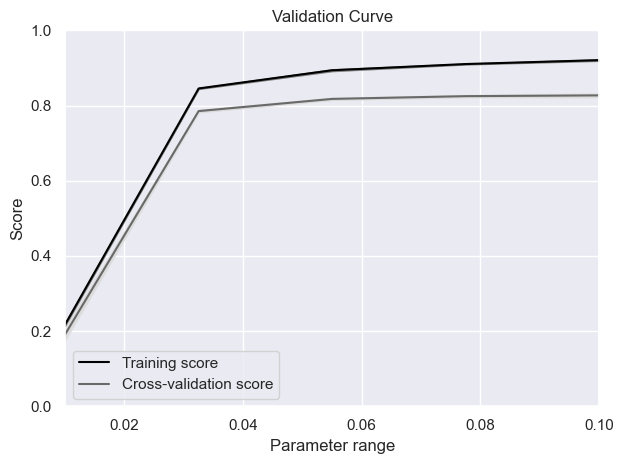

In [24]:
# Plot the validation curve:
%run "./recipes//plot_validation_curve.py"
plot_validation_curve(learning_rate, train_scores, test_scores)

In [25]:
best_learning_rate = learning_rate[test_scores.mean(axis=1).argmax()]
best_learning_rate

0.1

### Tune `n_estimators`

In [26]:
# Instantiate the model:
xgb_reg = XGBRegressor(
    max_depth=best_max_depth,
    learning_rate=best_learning_rate,
    random_state=42
);

In [27]:
# Create range of values for the hyperparameter in question:
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=5)]

In [28]:
%%time
# Perform CV using different hyperparametr values:
train_scores, test_scores = validation_curve(
    xgb_reg,
    X_train,
    y_train,
    param_name="n_estimators",
    param_range=n_estimators,
    cv=3,
    scoring=r2
)

CPU times: total: 7min 28s
Wall time: 2min 57s


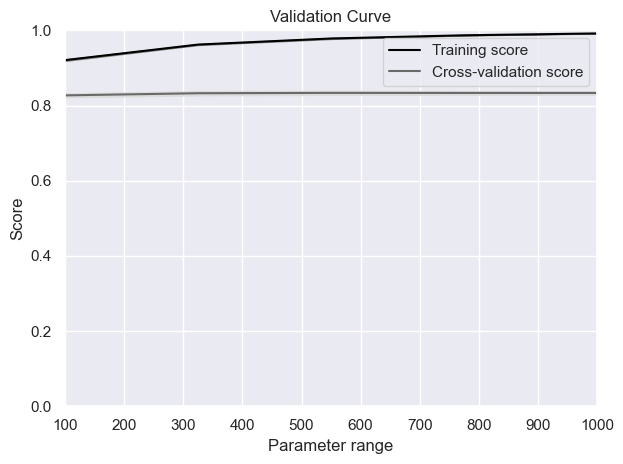

In [29]:
# Plot the validation curve:
%run "./recipes//plot_validation_curve.py"
plot_validation_curve(n_estimators, train_scores, test_scores)

In [30]:
best_n_estimators = n_estimators[test_scores.mean(axis=1).argmax()]
best_n_estimators

550

### Tune `min_child_weight`

In [31]:
# Instantiate the model:
xgb_reg = XGBRegressor(
    max_depth=best_max_depth,
    learning_rate=best_learning_rate,
    n_estimators=best_n_estimators,
    random_state=42
);

In [32]:
# Create range of values for the hyperparameter in question:
min_child_weight = [x for x in np.linspace(start=1, stop=10, num=5)]

In [33]:
%%time
# Perform CV using different hyperparametr values:
train_scores, test_scores = validation_curve(
    xgb_reg,
    X_train,
    y_train,
    param_name="min_child_weight",
    param_range=min_child_weight,
    cv=3,
    scoring=r2
)

CPU times: total: 8min 26s
Wall time: 2min 44s


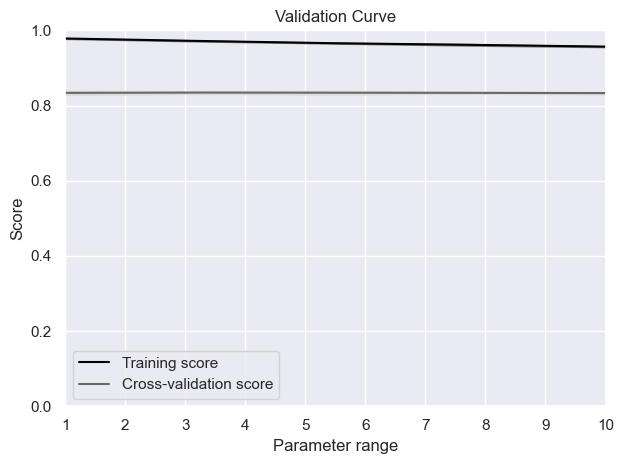

In [34]:
# Plot the validation curve:
%run "./recipes//plot_validation_curve.py"
plot_validation_curve(min_child_weight, train_scores, test_scores)

In [35]:
best_min_child_weight = min_child_weight[test_scores.mean(axis=1).argmax()]
best_min_child_weight

3.25

### Tune `gamma`

In [36]:
# Instantiate the model:
xgb_reg = XGBRegressor(
    max_depth=best_max_depth,
    learning_rate=best_learning_rate,
    n_estimators=best_n_estimators,
    min_child_weight=best_min_child_weight,
    random_state=42
);

In [37]:
# Create range of values for the hyperparameter in question:
gamma = [x for x in np.linspace(start=0.0, stop=1.0, num=5)]

In [38]:
%%time
# Perform CV using different hyperparametr values:
train_scores, test_scores = validation_curve(
    xgb_reg,
    X_train,
    y_train,
    param_name="gamma",
    param_range=gamma,
    cv=3,
    scoring=r2
)

CPU times: total: 8min 45s
Wall time: 2min 28s


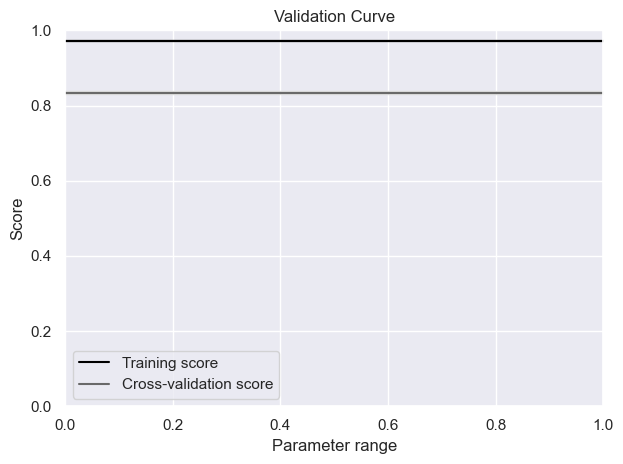

In [39]:
# Plot the validation curve:
%run "./recipes//plot_validation_curve.py"
plot_validation_curve(gamma, train_scores, test_scores)

In [40]:
best_gamma = gamma[test_scores.mean(axis=1).argmax()]
best_gamma

0.0

### Tune `subsample`

In [41]:
# Instantiate the model:
xgb_reg = XGBRegressor(
    max_depth=best_max_depth,
    learning_rate=best_learning_rate,
    n_estimators=best_n_estimators,
    min_child_weight=best_min_child_weight,
    gamma=best_gamma,
    random_state=42
);

In [42]:
# Create range of values for the hyperparameter in question:
subsample = [x for x in np.linspace(start=0.1, stop=1.0, num=5)]

In [43]:
%%time
# Perform CV using different hyperparametr values:
train_scores, test_scores = validation_curve(
    xgb_reg,
    X_train,
    y_train,
    param_name="subsample",
    param_range=subsample,
    cv=3,
    scoring=r2
)

CPU times: total: 6min 35s
Wall time: 2min 8s


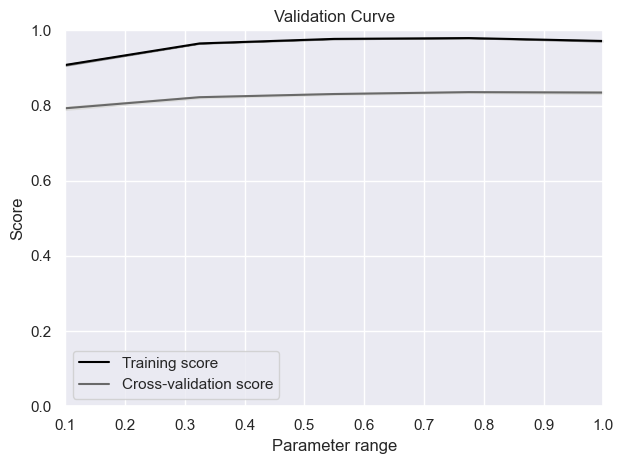

In [44]:
# Plot the validation curve:
%run "./recipes//plot_validation_curve.py"
plot_validation_curve(subsample, train_scores, test_scores)

In [45]:
best_subsample = subsample[test_scores.mean(axis=1).argmax()]
best_subsample

0.775

### Tune `colsample_bytree`

In [46]:
# Instantiate the model:
xgb_reg = XGBRegressor(
    max_depth=best_max_depth,
    learning_rate=best_learning_rate,
    n_estimators=best_n_estimators,
    min_child_weight=best_min_child_weight,
    gamma=best_gamma,
    subsample=best_subsample,
    random_state=42
);

In [47]:
# Create range of values for the hyperparameter in question:
colsample_bytree = [x for x in np.linspace(start=0.1, stop=1.0, num=5)]

In [48]:
%%time
# Perform CV using different hyperparametr values:
train_scores, test_scores = validation_curve(
    xgb_reg,
    X_train,
    y_train,
    param_name="colsample_bytree",
    param_range=colsample_bytree,
    cv=3,
    scoring=r2
)

CPU times: total: 5min 48s
Wall time: 1min 49s


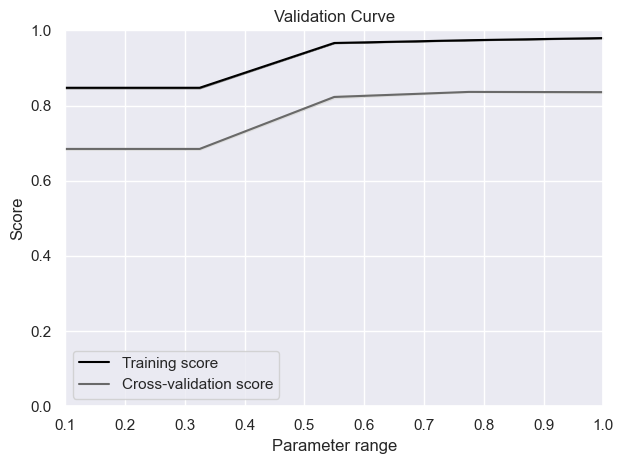

In [49]:
# Plot the validation curve:
%run "./recipes//plot_validation_curve.py"
plot_validation_curve(colsample_bytree, train_scores, test_scores)

In [50]:
best_colsample_bytree = colsample_bytree[test_scores.mean(axis=1).argmax()]
best_colsample_bytree

0.775

### Tune `reg_alpha`

In [51]:
# Instantiate the model:
xgb_reg = XGBRegressor(
    max_depth=best_max_depth,
    learning_rate=best_learning_rate,
    n_estimators=best_n_estimators,
    min_child_weight=best_min_child_weight,
    gamma=best_gamma,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    random_state=42
);

In [52]:
# Create range of values for the hyperparameter in question:
reg_alpha = [x for x in np.linspace(start=0.0, stop=1.0, num=5)]

In [53]:
%%time
# Perform CV using different hyperparametr values:
train_scores, test_scores = validation_curve(
    xgb_reg,
    X_train,
    y_train,
    param_name="reg_alpha",
    param_range=reg_alpha,
    cv=3,
    scoring=r2
)

CPU times: total: 6min 32s
Wall time: 1min 51s


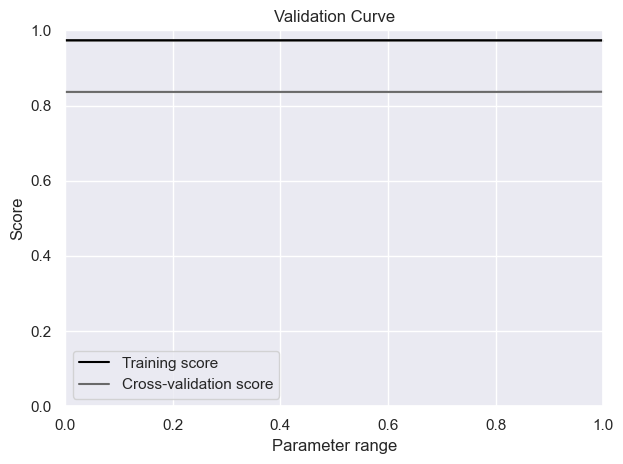

In [54]:
# Plot the validation curve:
%run "./recipes//plot_validation_curve.py"
plot_validation_curve(reg_alpha, train_scores, test_scores)

In [55]:
best_reg_alpha = reg_alpha[test_scores.mean(axis=1).argmax()]
best_reg_alpha

1.0

### Tune `reg_lambda`

In [56]:
# Instantiate the model:
xgb_reg = XGBRegressor(
    max_depth=best_max_depth,
    learning_rate=best_learning_rate,
    n_estimators=best_n_estimators,
    min_child_weight=best_min_child_weight,
    gamma=best_gamma,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    reg_alpha=best_reg_alpha,
    random_state=42
);

In [57]:
reg_lambda = [x for x in np.linspace(start=0.0, stop=1.0, num=5)]

In [58]:
%%time
# Perform CV using different hyperparametr values:
train_scores, test_scores = validation_curve(
    xgb_reg,
    X_train,
    y_train,
    param_name="reg_lambda",
    param_range=reg_lambda,
    cv=3,
    scoring=r2
)

CPU times: total: 6min 14s
Wall time: 1min 56s


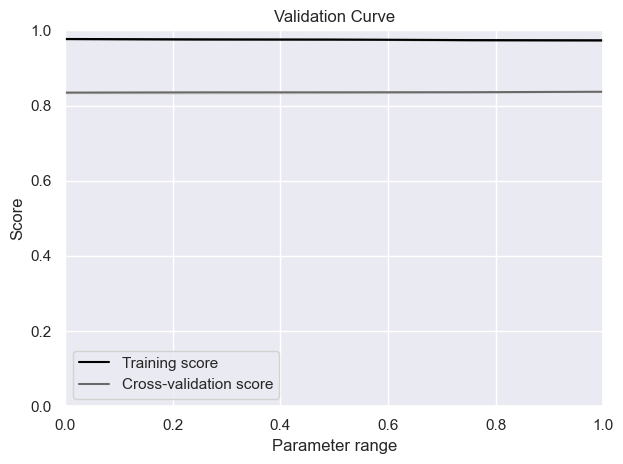

In [59]:
# Plot the validation curve:
%run "./recipes//plot_validation_curve.py"
plot_validation_curve(reg_lambda, train_scores, test_scores)

In [60]:
best_reg_lambda = reg_lambda[test_scores.mean(axis=1).argmax()]
best_reg_lambda

1.0

### Evaluate the model using the best-found hyperparameters (flawed but intuitive approach)

In [61]:
# Instantiate the xgb_reg baseline model:
xgb_reg = XGBRegressor(random_state=42);

In [62]:
# Instantiate the better xgb_reg model:
better_xgb_reg = XGBRegressor(
    max_depth=best_max_depth,
    learning_rate=best_learning_rate,
    n_estimators=best_n_estimators,
    min_child_weight=best_min_child_weight,
    gamma=best_gamma,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    reg_alpha=best_reg_alpha,
    reg_lambda=best_reg_lambda,
    random_state=42
);

Validating xgb_reg...
Validating xgb_reg done in 0.17 minutes!

Validating better_xgb_reg...
Validating better_xgb_reg done in 0.70 minutes!

                 min  mean   max
xgb_reg         0.81  0.83  0.84
better_xgb_reg  0.83  0.84  0.84




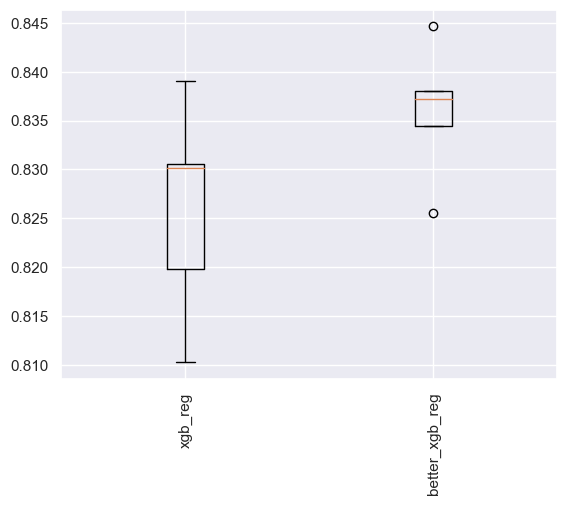

CPU times: total: 2min 45s
Wall time: 53.4 s


In [63]:
%%time
# Compare different models:
%run "./recipes/compare_models.py";
results = compare_models(
    X_train,
    y_train,
    r2,
    cv=5,
    xgb_reg=xgb_reg,
    better_xgb_reg=better_xgb_reg
);

## Step #04: Tuning the Model Hyperparameters

- What is hyperparameter tuning?
> - Hyperparameter tuning is the process of finding the optimal values for the hyperparameters of a machine learning model.
> - By selecting the best hyperparameter values, we can improve the model's performance and achieve better results. 

- Methods of hyperparameter tuning:
> - Grid Search,
> - Randomized Search,
> - Bayesian Optimization.

- Implementation using `optuna` Package:
> - `optuna` is a Python library for hyperparameter optimization.
> - It provides a flexible and easy-to-use framework for implementing hyperparameter tuning in machine learning projects.
> - Here's a basic outline of how to use Optuna for hyperparameter tuning:
>> - Define the `objective` function,
>> - Define the hyperparameter search space,
>> - Create a `study` object.

In [64]:
# Set optuna log level to WARNINGonly:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [65]:
# Define the objective function:
def objective(trial):
    
    # Define the hyperparameters:
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
    }

    # Train the model with CV:
    xgb_reg = XGBRegressor(random_state=42, **params)
    cv_results = cross_val_score(xgb_reg, X_train, y_train, scoring=r2, cv=3)

    # Evaluate the model
    r2_score = cv_results.mean()

    return r2_score

In [66]:
# Create a study:
study = optuna.create_study(direction='maximize');

In [67]:
%%time
# Run the study:
study.optimize(objective, n_trials=100)

CPU times: total: 3h 50min 49s
Wall time: 1h 10min 20s


In [68]:
# Print the best parameters:
opt_cv_best_params = study.best_params
print(opt_cv_best_params)

{'max_depth': 10, 'learning_rate': 0.013155106963212865, 'n_estimators': 998, 'min_child_weight': 1, 'gamma': 0.055849471931376335, 'subsample': 0.6951911710043644, 'colsample_bytree': 0.8463151750539947, 'reg_alpha': 0.8558224996136437, 'reg_lambda': 0.9031612921498501}


In [80]:
# Train the model with the best parameters:
hopefully_best_model = XGBRegressor(**opt_cv_best_params)
hopefully_best_model.fit(X_train, y_train);

Validating xgb_reg...
Validating xgb_reg done in 0.10 minutes!

Validating better_xgb_reg...
Validating better_xgb_reg done in 0.50 minutes!

Validating hopefully_best_model...
Validating hopefully_best_model done in 1.37 minutes!

                       min  mean   max
xgb_reg               0.81  0.83  0.84
better_xgb_reg        0.83  0.84  0.84
hopefully_best_model  0.83  0.85  0.85




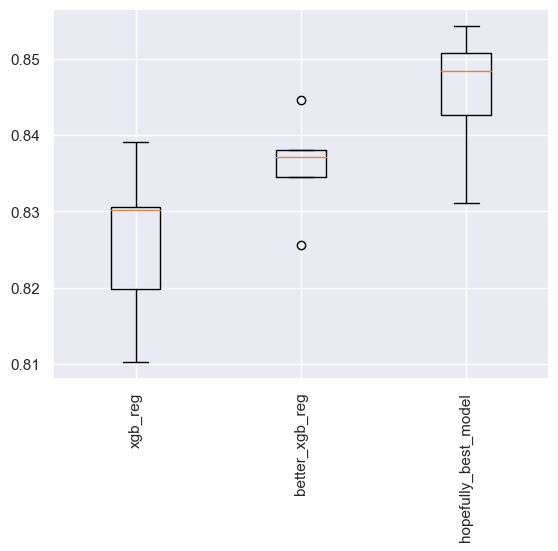

CPU times: total: 7min 17s
Wall time: 1min 59s


In [81]:
%%time
# Compare different models:
%run "./recipes/compare_models.py";
results = compare_models(
    X_train,
    y_train,
    r2,
    cv=5,
    xgb_reg=xgb_reg,
    better_xgb_reg=better_xgb_reg,
    hopefully_best_model=hopefully_best_model
);

## Step #05: Final Model Evaluation

In [82]:
# Instantiate the best model so far:
best_model_so_far = XGBRegressor(**opt_cv_best_params)

In [83]:
# Fit the model:
best_model_so_far.fit(X_train, y_train);

In [84]:
# Evaluate the model using r2:
best_r2_score = r2(best_model_so_far, X_test, y_test)
print(f"R-squared = {best_r2_score:.2%}")

R-squared = 85.18%


## Step #06: Saving Results

In [85]:
# Create a dictionary to hold the results:
feature_elimination_results = {
    "feature_names": feature_names,
    "X_train": X_train.astype(np.float32),
    "X_test": X_test.astype(np.float32),
    "y_train": y_train.astype(np.float32),
    "y_test": y_test.astype(np.float32)
}

In [86]:
# Pickle the results:
with open("./assets/feature_elimination_results.pkl", mode="wb") as file_bin:
    pickle.dump(feature_elimination_results, file_bin)

In [87]:
# Save the model:
best_model_so_far.save_model("./assets/best_model_so_far.json")

In [88]:
# Load the saved model:
saved_model = XGBRegressor()
saved_model.load_model("./assets/best_model_so_far.json");